# Imports

The required packages to run this notebook.  
If any are missing use ``!{sys.executable} -m pip install <package>`` to install the package in the notebook environment

In [1]:
import os.path
import gc 
import pandas as pd
import csv
import sys
from ctypes import cdll, CDLL
from urllib import parse
#!{sys.executable} -m pip install beautifulsoup4
from bs4 import BeautifulSoup
#!{sys.executable} -m pip install nbimporter
import nbimporter
import ARCH_Helper as ah
#!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
import multiprocessing
import time
import re

# Set Global variables

Set these variables before a run to determine how the proceccing is run.

The default Dataset options are "World", "German" or "Dutch", select these by altering the ```dataset``` variable.  
A custom dataset can be selected by setting the ```dataset``` variable to the path of the dataset. This cannot be "World", "German" or "Dutch"

In [2]:
# Dataset option are "World", "German" or "Dutch"
Dataset = "World"

The ```chunksize``` variable determines how much memory is used. A larger chunksize allows for faster computation, but will crash when RAM is full. If the computation crashes try restarting the kernel and/or a lower chunksize. 

The ```number_of_threads``` variables determines how much multiprocessing can take place. This can significantly speed up the running of the notebook but increases CPU core and memory use and my cause errors when more memory or threads are allocated than availible.

A ```chunksize``` of 1000 with ```number_of_threads``` set to 1 should be fine for most machines.

In [3]:
chunksize = 5000
number_of_threads = 12

```detection_patterns``` loads in a csv file holding the commenting systems and their detection patterns. This file can be updated with custom detection patterns or replaced with a different file.

In [4]:
detection_patterns = pd.read_csv("Commenting-system-detection-patterns.csv")

```general_detection_patterns``` loads in a csv file holding general detection patterns for commenting systems. This file can be updated with custom detection patterns or replaced with a different file.

In [5]:
general_detection_patterns = pd.read_csv("General-Commenting-system-detection-patterns.csv", delimiter=";")

# Download an archive
The script below makes a data folder with a subfolder for the dataset. The script wil skip files that are already present on the system. If you want to redownload the files first remove the old files manually.  
If the download fails due to connection errors, rerun the script and will will notice that he file did not decompress and try again.  
Note: The html-file-information.csv can be very large and take several hours and fail. Consider putting the code below code in a loop if you want to run it over night, if the download fails it will try again and if successfull it will say it already has the desired file.

In [6]:
if Dataset == "German" or Dataset == "World" or Dataset == "Dutch":
    !mkdir data
    !mkdir data/{Dataset}
    !mkdir data/{Dataset}/results

    if Dataset == "German":
        if not os.path.exists("data/German/domain-frequency.csv"):
            print("domain-frequency.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-germanNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/DomainFrequencyExtraction/domain-frequency.csv.gz?access=VRQ4COI5RFEB6XTJZNQTBRLEZTTHJERL" --output data/German/domain-frequency.csv.gz
            print("domain-frequency.csv has been downloaded")
        else:
            print("domain-frequency.csv already exists")

        if not os.path.exists("data/German/domain-graph.csv"):
            print("domain-graph.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-germanNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/DomainGraphExtraction/domain-graph.csv.gz?access=JKEPGQ6MUC72JQB23IXOC4KOLGJYDSMN" --output data/German/domain-graph.csv.gz
            print("domain-graph.csv has been downloaded")
        else:
            print("domain-frequency.csv already exists")

        if not os.path.exists("data/German/css-file-information.csv"):
            print("css-file-information.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-germanNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/css-file-information.csv.gz?access=I2WP4REJA3NOBU3TCAAL3OIGJKNXM46R" --output data/German/css-file-information.csv.gz
            print("css-file-information.csv has been downloaded")
        else:
            print("css-file-information.csv already exists")

        if not os.path.exists("data/German/js-file-information.csv"):
            print("js-file-information.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-germanNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/js-file-information.csv.gz?access=M3QSMFPLEHPZPWZIFSMZ6CT2OO7WYQ4M" --output data/German/js-file-information.csv.gz
            print("css-file-information.csv has been downloaded")
        else:
            print("js-file-information.csv already exists")

        if not os.path.exists("data/German/html-file-information.csv"):
            print("html-file-information.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-germanNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/html-file-information.csv.gz?access=E3BUHKL5P4Q3TD4LGXZV2AOMERYQ3GWL" --output data/German/html-file-information.csv.gz
            print("html-file-information.csv has been downloaded")
        else:
            print("html-file-information.csv already exists")

    if Dataset == "World":
        if not os.path.exists("data/World/domain-frequency.csv"):
            print("domain-frequency.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-worldNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/DomainFrequencyExtraction/domain-frequency.csv.gz?access=SMSQY3G6IGKGRWVLGCWMA7DMCHBCKQ4K" --output data/World/domain-frequency.csv.gz
            print("domain-frequency.csv has been downloaded")
        else:
            print("domain-frequency.csv already exists")

        if not os.path.exists("data/World/domain-graph.csv"):
            print("domain-graph.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-worldNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/DomainGraphExtraction/domain-graph.csv.gz?sample=true&access=BZTA7LW5LUNMPGKWQMLKAUAXBV2E2AEC" --output data/World/domain-graph.csv.gz
            print("domain-graph.csv has been downloaded")
        else:
            print("domain-frequency.csv already exists")

        if not os.path.exists("data/World/css-file-information.csv"):
            print("css-file-information.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-worldNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/css-file-information.csv.gz?access=UZ4PWVRXXWPF53BHM7TTYNK24P7YAIXQ" --output data/World/css-file-information.csv.gz
            print("css-file-information.csv has been downloaded")
        else:
            print("css-file-information.csv already exists")

        if not os.path.exists("data/World/js-file-information.csv"):
            print("js-file-information.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-worldNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/js-file-information.csv.gz?access=54X7IV7QOOAJWGHKPRGDI7HIR6W6GKPI" --output data/World/js-file-information.csv.gz
            print("css-file-information.csv has been downloaded")
        else:
            print("js-file-information.csv already exists")

        if not os.path.exists("data/World/html-file-information.csv"):
            print("html-file-information.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-worldNews_1st-in-month_1-hop_unique-EXTRACTION-20210818232425/TextFilesInformationExtraction/html-file-information.csv.gz?access=JQEDT3PRXOS6OXZ7LA5EC55HQJVUASDX" --output data/World/html-file-information.csv.gz
            print("html-file-information.csv has been downloaded")
        else:
            print("html-file-information.csv already exists")

    if Dataset == "Dutch":
        if not os.path.exists("data/Dutch/domain-frequency.csv"):
            print("domain-frequency.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-dutchNews_1st-in-month_1-hop_unique-EXTRACTION-20210916172606/DomainFrequencyExtraction/domain-frequency.csv.gz?access=QUQTRHVNIDKXN62S4D62XFHCFI7VDSH7" --output data/Dutch/domain-frequency.csv.gz
            print("domain-frequency.csv has been downloaded")
        else:
            print("domain-frequency.csv already exists")

        if not os.path.exists("data/Dutch/domain-graph.csv"):
            print("domain-graph.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-dutchNews_1st-in-month_1-hop_unique-EXTRACTION-20210916172606/DomainGraphExtraction/domain-graph.csv.gz?access=JUNESOMDTBYDNCCGVJI5MJHW45KHAIJZ" --output data/Dutch/domain-graph.csv.gz
            print("domain-graph.csv has been downloaded")
        else:
            print("domain-frequency.csv already exists")

        if not os.path.exists("data/Dutch/css-file-information.csv"):
            print("css-file-information.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-dutchNews_1st-in-month_1-hop_unique-EXTRACTION-20210916172606/TextFilesInformationExtraction/css-file-information.csv.gz?access=IGBKSGXJBL3L4IJ2LXS5NPJTOY77JCT5" --output data/Dutch/css-file-information.csv.gz
            print("css-file-information.csv has been downloaded")
        else:
            print("css-file-information.csv already exists")

        if not os.path.exists("data/Dutch/js-file-information.csv"):
            print("js-file-information.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-dutchNews_1st-in-month_1-hop_unique-EXTRACTION-20210916172606/TextFilesInformationExtraction/js-file-information.csv.gz?access=RPZKGWUTWJBIRKOKKHGECB7W4OHUATMO" --output data/Dutch/js-file-information.csv.gz
            print("css-file-information.csv has been downloaded")
        else:
            print("js-file-information.csv already exists")

        if not os.path.exists("data/Dutch/html-file-information.csv"):
            print("html-file-information.csv is not present")
            !curl "https://webdata.archive-it.org/ait/arch:cohort.helmond/research_services/download/SPECIAL-dutchNews_1st-in-month_1-hop_unique-EXTRACTION-20210916172606/TextFilesInformationExtraction/html-file-information.csv.gz?access=52ZOSNQQMFWKW42WMQPNMGKYLEVUQHUC" --output data/Dutch/html-file-information.csv.gz
            print("html-file-information.csv has been downloaded")
        else:
            print("html-file-information.csv already exists")

    unzip = "find data/" +Dataset +" -name '*.gz' -exec gunzip {} \;"
    !{unzip}
    dataset_location = "data/"+Dataset +"/html-file-information.csv"
else:
    !mkdir {Dataset}/results
    dataset_location = Dataset +"/html-file-information.csv"

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/World’: File exists
mkdir: cannot create directory ‘data/World/results’: File exists
domain-frequency.csv already exists
domain-frequency.csv already exists
css-file-information.csv already exists
js-file-information.csv already exists
html-file-information.csv already exists


Reduce the total dataset to only the domains that fit the research scope

In [7]:
dataset_in_scope_location = dataset_location[:-4]+"-in-scope.csv"

if Dataset == "Dutch":
    domains_in_scope = ["https://fd.nl/","https://www.ad.nl","https://www.nd.nl/","https://www.nrc.nl/","https://www.rd.nl/","https://www.telegraaf.nl/","https://www.trouw.nl","https://www.volkskrant.nl/","https://www.ewmagazine.nl/","https://www.bd.nl","https://www.bndestem.nl","https://www.destentor.nl","https://www.dvhn.nl","https://www.ed.nl","https://www.gelderlander.nl","https://www.haarlemsdagblad.nl/","https://www.lc.nl/","https://www.leidschdagblad.nl/","https://www.limburger.nl","https://www.noordhollandsdagblad.nl","https://www.parool.nl","https://www.pzc.nl","https://www.tubantia.nl","https://jeugdjournaal.nl/","https://nieuws.nl/","https://nos.nl/","https://www.1limburg.nl/","https://www.businessinsider.nl/","https://www.dutchnews.nl/","https://www.ewmagazine.nl/","https://www.geenstijl.nl/","https://www.kliknieuws.nl/","https://www.metronieuws.nl/","https://www.nhnieuws.nl/","https://www.ninefornews.nl/","https://www.nu.nl/","https://www.quotenet.nl","https://www.rtlnieuws.nl","https://www.tpo.nl","https://www.welingelichtekringen.nl","https://www.hartvannederland.nl/","https://www.bnr.nl/","https://www.dagelijksestandaard.nl/","http://www.joop.nl/","https://www.hpdetijd.nl/","https://www.groene.nl/","https://www.oneworld.nl/","https://www.vn.nl/","https://sargasso.nl/","https://www.powned.tv/"]
    domains_in_scope = list(map(ah.to_domain, domains_in_scope))
elif Dataset == "World":
    domains_in_scope = ["https://cnn.com","https://www.nytimes.com/","https://www.theguardian.com/","https://www.indiatimes.com/","https://www.foxnews.com/","https://www.washingtonpost.com/","https://usatoday.com","https://www.cnbc.com","http://www.chinadaily.com.cn/","https://www.thehindu.com/","https://www.wsj.com","https://nypost.com/","https://www.huffingtonpost.com","https://abcnews.go.com/","https://www.bbc.com/","https://www.dailymail.co.uk/","https://timesofindia.indiatimes.com/","https://www.independent.co.uk/","https://www.smh.com.au/","https://www.telegraph.co.uk/","https://www.latimes.com/","https://www.sfgate.com/","https://www.nbcnews.com/","https://buzzfeednews.com","https://aljazeera.com","https://rt.com","https://reuters.com","https://npr.org","https://sputniknews.com","https://cbsnews.com","https://cbc.ca","https://abc.net.au","https://time.com","https://mirror.co.uk","https://thesun.co.uk","https://euronews.com","https://ctvnews.ca","https://vox.com","https://scmp.com","https://france24.com","https://express.co.uk","https://news.sky.com","https://news24.com","https://globalnews.ca","https://channelnewsasia.com","https://rawstory.com","https://washingtontimes.com","https://todayonline.com","https://dailytelegraph.com.au","https://csmonitor.com"]
    domains_in_scope = list(map(ah.to_domain, domains_in_scope))
elif Dataset == "German":
    domains_in_scope = ["https://www.bild.de","https://www.waz.de","https://www.zeit.de/","https://www.sueddeutsche.de","https://www.welt.de/","https://rp-online.de/","https://www.faz.net/","https://www.augsburger-allgemeine.de/","https://www.allgaeuer-zeitung.de/","https://www.freiepresse.de","https://www.merkur.de","https://www.lvz.de","https://www.mz.de","https://www.wn.de","https://www.hna.de","https://www.rheinpfalz.de","https://www.volksstimme.de","https://www.handelsblatt.com","https://taz.de","https://www.nd-aktuell.de","https://jungefreiheit.de","https://www.freitag.de","http://www.das-parlament.de","https://www.juedische-allgemeine.de","https://www.fr.de","https://www.abendblatt.de","https://www.morgenpost.de","https://www.tagesspiegel.de","https://www.bz-berlin.de","https://www.ftd.de","https://www.ksta.de/","https://www.stuttgarter-zeitung.de","https://www.badische-zeitung.de","https://www.tz.de","https://www.mopo.de","https://www.berliner-zeitung.de","https://www.haz.de","https://www.stuttgarter-nachrichten.de","http://www.spiegel.de/","https://www.deutschlandfunk.de/","https://www.focus.de/","https://www.stern.de/","https://www.zdf.de/","https://wdr.de/","https://www.ndr.de/","https://www.br.de/","https://www.swr.de/","https://www.mainpost.de/","https://www.nwzonline.de/","https://mads.de/"]
    domains_in_scope = list(map(ah.to_domain, domains_in_scope))
else:
    dataset_in_scope_location = dataset_location
if not os.path.exists(dataset_in_scope_location):
    ah.filter_csv_domains(dataset_location, dataset_in_scope_location, domains_in_scope, chunksize)


# Extract wepages holding signs of known commenting systems in their HTML

The code bellow loops through the known commenting systems and their detection patterns, saving them per commenting system in a CSV file at ``"data/"+Dataset +"/results/"+system+".csv"`` and a summary file at ``"data/"+Dataset +"/results/"+system+"-summary.csv"``

In [8]:
def detect_system(system):
    system_df_list = []
    for index, row in detection_patterns[detection_patterns['Commenting system'] == system].iterrows():
        system_df = ah.filter_csv_content_regex(dataset_in_scope_location, row['Regex'], chunksize)
        system_df[row['Snippet']]=True
        system_df_list.append(system_df)

    system_df = pd.concat(system_df_list)
    
    #merge individual snippet hits
    system_df = system_df.groupby(["crawl_date","url"]).first().reset_index()
    
    system_df["year"] = system_df["crawl_date"].div(10000).round().astype(int)
    system_df["domain"] = system_df['url'].apply(ah.to_domain)
    
    system_df = system_df.fillna(False)
    
    save_location = "data/"+Dataset +"/results/"+system+".csv"
    ah.save_dataframe(system_df, save_location)
    
    snippets = list(detection_patterns[detection_patterns['Commenting system'] == system]['Snippet'])
    result_scope = ['year','domain']
    result_scope.extend(snippets)
    
    system_results = pd.DataFrame(system_df[result_scope].value_counts().sort_index()).reset_index()
    system_results.rename(columns={0:'count'}, inplace=True)
    
    save_location = "data/"+Dataset +"/results/"+system+"-summary.csv"
    ah.save_dataframe(system_results, save_location)
    

systems = list(detection_patterns['Commenting system'].unique())
pool = multiprocessing.Pool(number_of_threads)
pool.map(detect_system, systems)
pool.close()

Display extended summeries for each of the commenting systems

Overlap between identifiers for Disqus:

data-disqus-identifier  disqus.com/embed.js  disqus_thread
False                   False                True             43
                        True                 True             35
True                    False                True             16
                        True                 True             15
                        False                False             7
dtype: int64


cnn.com uses  Disqus  in: [2010, 2011, 2012, 2013, 2014, 2015, 2016]
csmonitor.com uses  Disqus  in: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
foxnews.com uses  Disqus  in: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
independent.co.uk uses  Disqus  in: [2010, 2011, 2012, 2013]
rawstory.com uses  Disqus  in: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
telegraph.co.uk uses  Disqus  in: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
aljazeera.com uses  Disqus  in: [2011, 2012, 2013, 2014, 20

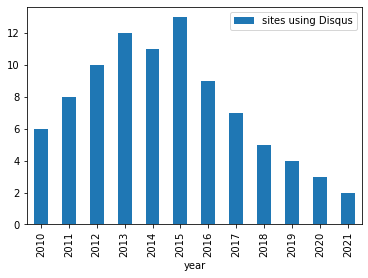

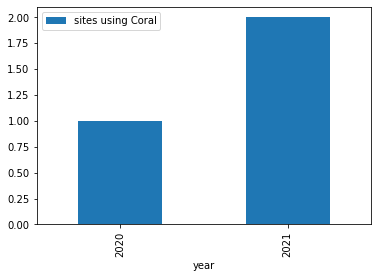

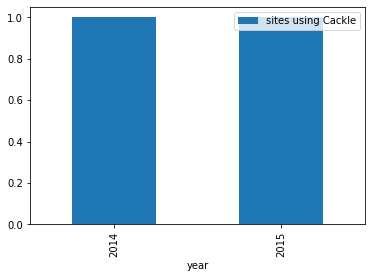

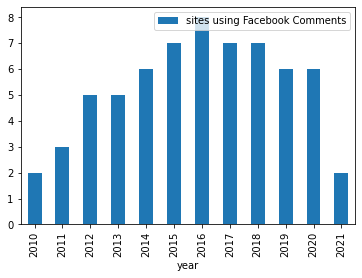

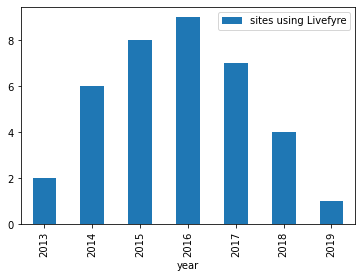

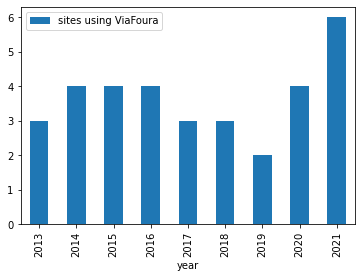

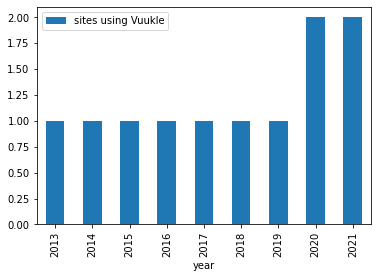

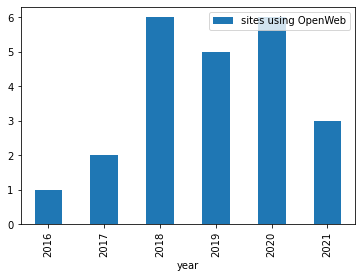

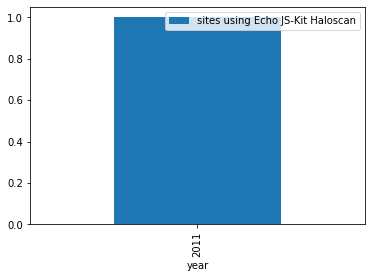

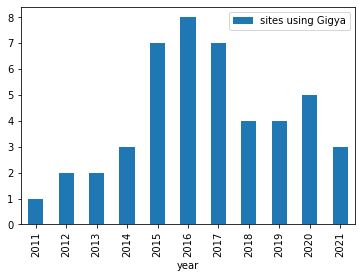

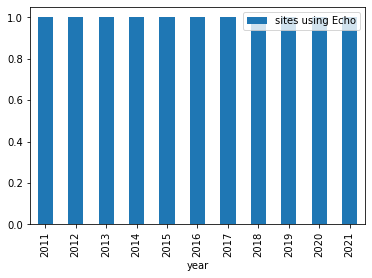

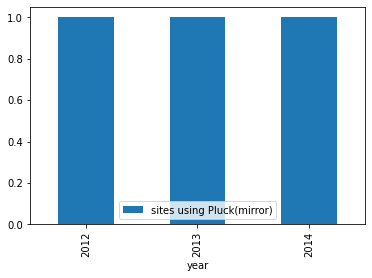

In [9]:
for system in list(detection_patterns['Commenting system'].unique()):
    save_location = "data/"+Dataset +"/results/"+system+"-summary.csv"
    results = pd.read_csv(save_location)
    domains = list(results.domain.unique())
    
    #skip to next itteration if no domains found with system
    if domains == []:
        continue

    identifiers = results.columns.values.tolist()
    identifiers = [x for x in identifiers if x not in ['year','domain','count']]
    print("Overlap between identifiers for "+system+":")
    print()
    print(results[identifiers].value_counts())
    print()
    
    print()
    for domain in domains:
        years = list(results[results.domain == domain].year.unique())
        print(domain, "uses ", system," in:", years)
    
    print()
    print("Number of sites using "+system+" per year:")
    sites_per_year = pd.DataFrame(results[["year", "domain"]].drop_duplicates()["year"].value_counts().sort_index()).reset_index()
    sites_per_year.columns = ["year", "sites using "+system ]
    
    print(sites_per_year)
    sites_per_year.plot(x='year', kind = 'bar')
    print()

Display total commenting systems per year

    year  number of commenting systems
0   2007                             0
1   2008                             0
2   2009                             0
3   2010                             8
4   2011                            14
5   2012                            19
6   2013                            27
7   2014                            34
8   2015                            42
9   2016                            41
10  2017                            35
11  2018                            31
12  2019                            24
13  2020                            28
14  2021                            21


<AxesSubplot:xlabel='year'>

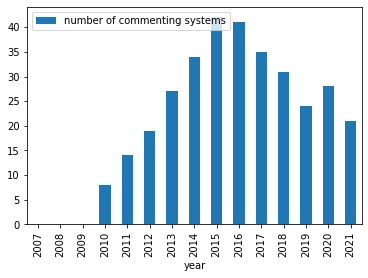

In [10]:
years = range(2007,2022)
commenting_systems_per_year = pd.DataFrame(0,index=[list(years)], columns=["count"])

for system in list(detection_patterns['Commenting system'].unique()):
    save_location = "data/"+Dataset +"/results/"+system+"-summary.csv"
    results = pd.read_csv(save_location)
    domains = list(results.domain.unique())
    
    #skip to next itteration if no domains found with system
    if domains == []:
        continue

    for domain in domains:
        years_in_system = list(results[results.domain == domain].year.unique())
        for year in years_in_system:
            commenting_systems_per_year.loc[year, 'count'] += 1

commenting_systems_per_year = commenting_systems_per_year.reset_index(level=0)
commenting_systems_per_year.columns = ["year", "number of commenting systems"]
print(commenting_systems_per_year)
commenting_systems_per_year.plot(x='year', kind = 'bar')

Display total unique commenting systems per year

    year  number of unique commenting systems
0   2007                                    0
1   2008                                    0
2   2009                                    0
3   2010                                    2
4   2011                                    5
5   2012                                    5
6   2013                                    8
7   2014                                    9
8   2015                                    8
9   2016                                    8
10  2017                                    8
11  2018                                    8
12  2019                                    8
13  2020                                    8
14  2021                                    8


<AxesSubplot:xlabel='year'>

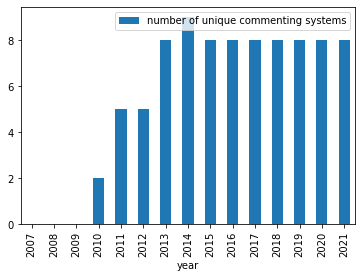

In [11]:
years = range(2007,2022)
unique_commenting_systems_per_year = pd.DataFrame(0,index=[list(years)], columns=["count"])

for system in list(detection_patterns['Commenting system'].unique()):
    save_location = "data/"+Dataset +"/results/"+system+"-summary.csv"
    results = pd.read_csv(save_location)
    years_tmp = list(results.year.unique())
    
    #skip to next itteration if no domains found with system
    if years_tmp == []:
        continue

    for year in years_tmp:
        unique_commenting_systems_per_year.loc[year, 'count'] += 1

unique_commenting_systems_per_year = unique_commenting_systems_per_year.reset_index(level=0)
unique_commenting_systems_per_year.columns = ["year", "number of unique commenting systems"]
print(unique_commenting_systems_per_year)
unique_commenting_systems_per_year.plot(x='year', kind = 'bar')

Display and save a matrix with the commenting system per domain per year

In [12]:
years = range(2007,2022)
commenting_systems_per_domain = pd.DataFrame(index=[list(years)], columns=[domains_in_scope])
#commenting_systems_per_year = commenting_systems_per_year.fillna("")

for system in list(detection_patterns['Commenting system'].unique()):
    save_location = "data/"+Dataset +"/results/"+system+"-summary.csv"
    results = pd.read_csv(save_location)
    domains = list(results.domain.unique())
    
    #skip to next itteration if no domains found with system
    if domains == []:
        continue

    for domain in domains:
        years_in_system = list(results[results.domain == domain].year.unique())
        for year in years_in_system:
            #print(commenting_systems_per_year.loc[year, domain].dropna().empty)
            if commenting_systems_per_domain.loc[year, domain].dropna().empty:
                commenting_systems_per_domain.loc[year, domain] = system
            else :
                tmp = commenting_systems_per_domain.loc[year, domain] + "; " + system
                commenting_systems_per_domain.loc[year, domain] = tmp

commenting_systems_per_domain = commenting_systems_per_domain.fillna("").transpose()
save_location = "data/"+Dataset +"/results/domain-summary.csv"
commenting_systems_per_domain.to_csv(save_location)
commenting_systems_per_domain

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
cnn.com,,,,Disqus,Disqus,Disqus,Disqus,Disqus,Disqus; Livefyre,Disqus; Livefyre,Livefyre,Livefyre,Livefyre,,
nytimes.com,,,,,,,,,,,,,,,
theguardian.com,,,,,,,,,,,,,,,
indiatimes.com,,,,,,,,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,
foxnews.com,,,,Disqus,Disqus,Disqus,Disqus,Disqus; Livefyre,Disqus; Livefyre,Disqus; Livefyre,Disqus; Livefyre,Disqus,,OpenWeb,
washingtonpost.com,,,,Facebook Comments,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo
usatoday.com,,,,,,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,
cnbc.com,,,,,,,Disqus,Disqus,Disqus,Disqus,,,,,
chinadaily.com.cn,,,,,,,,,,,,,,,
thehindu.com,,,,,,,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle


In the previous matrix, fill in for which years there is no data availible in the dataset.

In [13]:
dataset_location = "data/"+Dataset +"/html-file-information.csv"
dataset_in_scope_location = dataset_location[:-4]+"-in-scope.csv"

col_list = ["crawl_date", "url"]
data = pd.read_csv(dataset_in_scope_location,usecols=col_list)
data["url"] = data["url"].apply(ah.to_domain)
data["year"] = data["crawl_date"].div(10000).round().astype(int)
for site in domains_in_scope:
    site_years = data[data["url"] == site]["year"].value_counts().sort_index().index.tolist()
    for year in years:
        if year not in site_years:
            commenting_systems_per_domain.loc[site, year] = "Data unavailable"

del data
save_location = "data/"+Dataset +"/results/domain-summary.csv"
commenting_systems_per_domain.to_csv(save_location)
commenting_systems_per_domain

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
cnn.com,Data unavailable,Data unavailable,,Disqus,Disqus,Disqus,Disqus,Disqus,Disqus; Livefyre,Disqus; Livefyre,Livefyre,Livefyre,Livefyre,,
nytimes.com,Data unavailable,Data unavailable,,,,,,,,,,,,,
theguardian.com,Data unavailable,Data unavailable,Data unavailable,Data unavailable,Data unavailable,Data unavailable,Data unavailable,,Data unavailable,,Data unavailable,Data unavailable,Data unavailable,Data unavailable,
indiatimes.com,Data unavailable,Data unavailable,Data unavailable,,,,,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,
foxnews.com,,Data unavailable,,Disqus,Disqus,Disqus,Disqus,Disqus; Livefyre,Disqus; Livefyre,Disqus; Livefyre,Disqus; Livefyre,Disqus,,OpenWeb,
washingtonpost.com,,,,Facebook Comments,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo
usatoday.com,Data unavailable,,,,,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,
cnbc.com,Data unavailable,Data unavailable,,,,,Disqus,Disqus,Disqus,Disqus,,,,,
chinadaily.com.cn,Data unavailable,Data unavailable,,,,,,,,,,,,,
thehindu.com,Data unavailable,Data unavailable,Data unavailable,Data unavailable,,,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle


# Create subset that does not have commenting systems identified

Loop through all the pages that have a commenting system positivly identified and remove them from the dataset in scope

In [14]:
total_dataset_location = dataset_in_scope_location
start_size = os.path.getsize(dataset_in_scope_location)
print("stating file has size ", start_size)
#total_dataset_location = "data/World/html-file-information-2016.csv"
tmp_save_location = "data/"+Dataset +"/tmp.csv"
save_location = "data/"+Dataset +"/no-positive-detections.csv"
headers = ["crawl_date","url","filename","extension","mime_type_web_server","mime_type_tika","md5","sha1","content"]

for system in list(detection_patterns['Commenting system'].unique()):
    system_to_remove_location = "data/"+Dataset +"/results/"+system+".csv"
    ah.csv_complement(system_to_remove_location, total_dataset_location,headers,tmp_save_location, chunksize*10)
    current_size = os.path.getsize(tmp_save_location)
    percentage = (current_size / start_size) * 100
    print("size after removing "+system," is ", current_size, " ", percentage, "% of the original size")
    !mv {tmp_save_location} {save_location}
    total_dataset_location = save_location

stating file has size  32673355301
size after removing Disqus  is  31235465425   95.59919738039272 % of the original size
size after removing Coral  is  31181565156   95.43423033460435 % of the original size
size after removing Cackle  is  31181565156   95.43423033460435 % of the original size
size after removing Facebook Comments  is  30373944846   92.962429374587 % of the original size
size after removing Insticator Commenting  is  30373944846   92.962429374587 % of the original size
size after removing Livefyre  is  30214363343   92.47401457442376 % of the original size
size after removing ViaFoura  is  26980887833   82.57764647812043 % of the original size
size after removing Vuukle  is  26223300465   80.25897623130676 % of the original size
size after removing OpenWeb  is  25521051167   78.1096735608874 % of the original size
size after removing Commentics  is  25521051167   78.1096735608874 % of the original size
size after removing Echo JS-Kit Haloscan  is  25520988688   78.1094

# Extract wepages holding signs of commenting systems in their HTML

The code bellow loops through the known commenting systems and their detection patterns, saving them per commenting system in a CSV file at ``"data/"+Dataset +"/results/"+snippet+".csv"`` and a summary file at ``"data/"+Dataset +"/results/"+snippet+"-summary.csv"``

In [15]:
total_dataset_location = "data/"+Dataset +"/no-positive-detections.csv"

In [16]:
def detect_unkown_system(snippet):
    #print("Starting with search of ", snippet)
    regex = general_detection_patterns['Regex'][general_detection_patterns['Snippet']== snippet].values.item()
    snippet_df = ah.filter_csv_content_regex(total_dataset_location, regex, chunksize)
    snippet_df[snippet]=True
    #print("Done with search of ", snippet)
    
    #merge individual snippet hits
    #system_df = system_df.groupby(["crawl_date","url"]).first().reset_index()
    
    snippet_df["year"] = snippet_df["crawl_date"].div(10000).round().astype(int)
    snippet_df["domain"] = snippet_df['url'].apply(ah.to_domain)
    
    snippet_df = snippet_df.fillna(False)
    
    save_location = "data/"+Dataset +"/results/"+snippet+".csv"
    ah.save_dataframe(snippet_df, save_location)
    #print("saved ", snippet)
    
    #snippets = list(detection_patterns[detection_patterns['Commenting system'] == system]['Snippet'])
    result_scope = ['year','domain', snippet]
    #result_scope.extend(snippet)
    
    snippet_results = pd.DataFrame(snippet_df[result_scope].value_counts().sort_index()).reset_index()
    snippet_results.rename(columns={0:'count'}, inplace=True)
    #print("summary ", snippet)
    save_location = "data/"+Dataset +"/results/"+snippet+"-summary.csv"
    ah.save_dataframe(snippet_results, save_location)
    

snippets = list(general_detection_patterns['Snippet'].unique())
pool = multiprocessing.Pool(number_of_threads)
pool.map(detect_unkown_system, snippets)
pool.close()

aljazeera.com has comment in id variable in: [2008, 2010, 2011, 2012, 2013, 2014, 2015, 2017, 2018, 2019, 2020]
cbsnews.com has comment in id variable in: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
sfgate.com has comment in id variable in: [2008, 2010, 2011, 2012, 2013, 2014, 2016, 2017, 2018, 2019, 2020, 2021]
washingtonpost.com has comment in id variable in: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
abcnews.go.com has comment in id variable in: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
cnn.com has comment in id variable in: [2009, 2010, 2012, 2013, 2014, 2015, 2016, 2017, 2019, 2020]
huffingtonpost.com has comment in id variable in: [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2019]
latimes.com has comment in id variable in: [2009, 2010, 2011, 2012, 2013, 2014, 2018, 2019]
npr.org has comment in id variable in: [2009, 2010, 2011, 2012, 2013, 2014, 2016, 

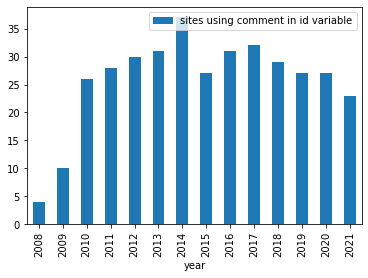

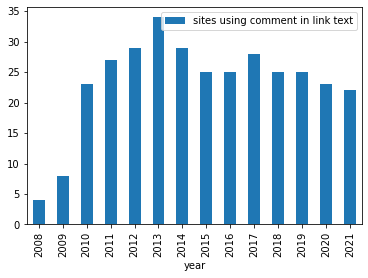

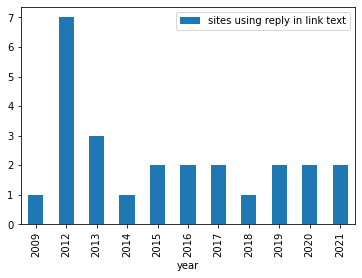

In [17]:
for snippet in list(general_detection_patterns['Snippet'].unique()):
    save_location = "data/"+Dataset +"/results/"+snippet+"-summary.csv"
    results = pd.read_csv(save_location)
    domains = list(results.domain.unique())
    
    #skip to next itteration if no domains found with system
    if domains == []:
        continue

#    identifiers = results.columns.values.tolist()
#    identifiers = [x for x in identifiers if x not in ['year','domain','count']]
#    print("Overlap between identifiers for "+system+":")
#    print()
#    print(results[identifiers].value_counts())
#    print()
    
#    print()
    for domain in domains:
        years = list(results[results.domain == domain].year.unique())
        print(domain, "has", snippet,"in:", years)
    
    print()
    print("Number of sites having "+snippet+" per year:")
    sites_per_year = pd.DataFrame(results[["year", "domain"]].drop_duplicates()["year"].value_counts().sort_index()).reset_index()
    sites_per_year.columns = ["year", "sites using "+snippet ]
    
    print(sites_per_year)
    sites_per_year.plot(x='year', kind = 'bar')
    print()

    year  number of commenting snippets
0   2007                              0
1   2008                              8
2   2009                             19
3   2010                             49
4   2011                             55
5   2012                             66
6   2013                             68
7   2014                             67
8   2015                             54
9   2016                             58
10  2017                             62
11  2018                             55
12  2019                             54
13  2020                             52
14  2021                             47


<AxesSubplot:xlabel='year'>

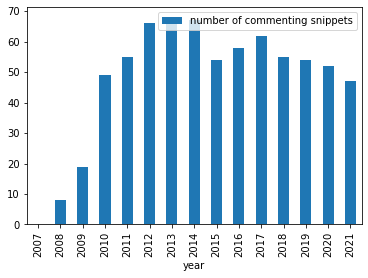

In [18]:
years = range(2007,2022)
commenting_snippets_per_year = pd.DataFrame(0,index=[list(years)], columns=["count"])

for snippet in list(general_detection_patterns['Snippet'].unique()):
    save_location = "data/"+Dataset +"/results/"+snippet+"-summary.csv"
    results = pd.read_csv(save_location)
    domains = list(results.domain.unique())
    
    #skip to next itteration if no domains found with system
    if domains == []:
        continue

    for domain in domains:
        years_in_snippet = list(results[results.domain == domain].year.unique())
        for year in years_in_snippet:
            commenting_snippets_per_year.loc[year, 'count'] += 1

commenting_snippets_per_year = commenting_snippets_per_year.reset_index(level=0)
commenting_snippets_per_year.columns = ["year", "number of commenting snippets"]
print(commenting_snippets_per_year)
commenting_snippets_per_year.plot(x='year', kind = 'bar')

In [19]:
years = range(2007,2022)
commenting_snippets_per_domain = pd.DataFrame(index=[list(years)], columns=[domains_in_scope])
#commenting_systems_per_year = commenting_systems_per_year.fillna("")

for snippet in list(general_detection_patterns['Snippet'].unique()):
    save_location = "data/"+Dataset +"/results/"+snippet+"-summary.csv"
    results = pd.read_csv(save_location)
    domains = list(results.domain.unique())
    
    #skip to next itteration if no domains found with system
    if domains == []:
        continue

    for domain in domains:
        years_in_snippet = list(results[results.domain == domain].year.unique())
        for year in years_in_snippet:
            #print(commenting_systems_per_year.loc[year, domain].dropna().empty)
            if commenting_snippets_per_domain.loc[year, domain].dropna().empty:
                commenting_snippets_per_domain.loc[year, domain] = snippet
            else :
                tmp = commenting_snippets_per_domain.loc[year, domain] + "; " + snippet
                commenting_snippets_per_domain.loc[year, domain] = tmp

commenting_snippets_per_domain = commenting_snippets_per_domain.fillna("").transpose()
save_location = "data/"+Dataset +"/results/snippet-domain-summary.csv"
commenting_snippets_per_domain.to_csv(save_location)
commenting_snippets_per_domain

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
cnn.com,,,comment in id variable; comment in link text; ...,comment in id variable; comment in link text,comment in link text,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,,comment in id variable; comment in link text,comment in id variable; comment in link text,
nytimes.com,,,,comment in id variable; comment in link text,comment in id variable,comment in id variable; comment in link text; ...,comment in id variable,comment in id variable; comment in link text,comment in id variable; reply in link text,comment in id variable,,,,,
theguardian.com,,,,,,,,comment in link text,,comment in id variable; comment in link text,,,,,comment in id variable
indiatimes.com,,,,,,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,,,,comment in id variable,,comment in id variable,
foxnews.com,,,,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable,comment in id variable; comment in link text,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text
washingtonpost.com,,comment in id variable; comment in link text,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable
usatoday.com,,,comment in id variable,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text; ...,,comment in id variable,comment in id variable,,,,,,
cnbc.com,,,,comment in id variable,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in link text,comment in link text,comment in link text,comment in link text,comment in link text,comment in link text,comment in link text,comment in link text
chinadaily.com.cn,,,,,comment in link text,comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in link text
thehindu.com,,,,,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,,comment in link text,comment in link text,comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text


In the previous matrix, fill in for which years there is no data availible in the dataset.

In [20]:
dataset_location = "data/"+Dataset +"/html-file-information.csv"
dataset_in_scope_location = dataset_location[:-4]+"-in-scope.csv"

col_list = ["crawl_date", "url"]
data = pd.read_csv(dataset_in_scope_location,usecols=col_list)
data["url"] = data["url"].apply(ah.to_domain)
data["year"] = data["crawl_date"].div(10000).round().astype(int)
for site in domains_in_scope:
    site_years = data[data["url"] == site]["year"].value_counts().sort_index().index.tolist()
    for year in years:
        if year not in site_years:
            commenting_snippets_per_domain.loc[site, year] = "Data unavailable"

del data
save_location = "data/"+Dataset +"/results/snippet-domain-summary.csv"
commenting_snippets_per_domain.to_csv(save_location)
commenting_snippets_per_domain

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
cnn.com,Data unavailable,Data unavailable,comment in id variable; comment in link text; ...,comment in id variable; comment in link text,comment in link text,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,,comment in id variable; comment in link text,comment in id variable; comment in link text,
nytimes.com,Data unavailable,Data unavailable,,comment in id variable; comment in link text,comment in id variable,comment in id variable; comment in link text; ...,comment in id variable,comment in id variable; comment in link text,comment in id variable; reply in link text,comment in id variable,,,,,
theguardian.com,Data unavailable,Data unavailable,Data unavailable,Data unavailable,Data unavailable,Data unavailable,Data unavailable,comment in link text,Data unavailable,comment in id variable; comment in link text,Data unavailable,Data unavailable,Data unavailable,Data unavailable,comment in id variable
indiatimes.com,Data unavailable,Data unavailable,Data unavailable,,,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,,,,comment in id variable,,comment in id variable,
foxnews.com,,Data unavailable,,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable,comment in id variable; comment in link text,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text
washingtonpost.com,,comment in id variable; comment in link text,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable
usatoday.com,Data unavailable,,comment in id variable,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text; ...,,comment in id variable,comment in id variable,,,,,,
cnbc.com,Data unavailable,Data unavailable,,comment in id variable,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in link text,comment in link text,comment in link text,comment in link text,comment in link text,comment in link text,comment in link text,comment in link text
chinadaily.com.cn,Data unavailable,Data unavailable,,,comment in link text,comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in link text
thehindu.com,Data unavailable,Data unavailable,Data unavailable,Data unavailable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,,comment in link text,comment in link text,comment in link text,comment in id variable; comment in link text,comment in id variable; com

Fill in gaps of known commenting systems with general results

In [21]:
merged = commenting_systems_per_domain.copy()
for index in commenting_systems_per_domain.index:
    for column in commenting_systems_per_domain.columns:
        if commenting_systems_per_domain.loc[index,column] == "":
            merged.loc[index,column] = commenting_snippets_per_domain.loc[index,column]
            
save_location = "data/"+Dataset +"/results/merged-domain-summary.csv"
merged.to_csv(save_location)
merged

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
cnn.com,Data unavailable,Data unavailable,comment in id variable; comment in link text; ...,Disqus,Disqus,Disqus,Disqus,Disqus,Disqus; Livefyre,Disqus; Livefyre,Livefyre,Livefyre,Livefyre,comment in id variable; comment in link text,
nytimes.com,Data unavailable,Data unavailable,,comment in id variable; comment in link text,comment in id variable,comment in id variable; comment in link text; ...,comment in id variable,comment in id variable; comment in link text,comment in id variable; reply in link text,comment in id variable,,,,,
theguardian.com,Data unavailable,Data unavailable,Data unavailable,Data unavailable,Data unavailable,Data unavailable,Data unavailable,comment in link text,Data unavailable,comment in id variable; comment in link text,Data unavailable,Data unavailable,Data unavailable,Data unavailable,comment in id variable
indiatimes.com,Data unavailable,Data unavailable,Data unavailable,,,comment in id variable,comment in id variable; comment in link text,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,
foxnews.com,,Data unavailable,,Disqus,Disqus,Disqus,Disqus,Disqus; Livefyre,Disqus; Livefyre,Disqus; Livefyre,Disqus; Livefyre,Disqus,comment in id variable; comment in link text,OpenWeb,comment in id variable; comment in link text
washingtonpost.com,,comment in id variable; comment in link text,comment in id variable,Facebook Comments,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo,Echo
usatoday.com,Data unavailable,,comment in id variable,comment in id variable,comment in id variable; comment in link text,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,Facebook Comments,
cnbc.com,Data unavailable,Data unavailable,,comment in id variable,comment in id variable,comment in id variable; comment in link text,Disqus,Disqus,Disqus,Disqus,comment in link text,comment in link text,comment in link text,comment in link text,comment in link text
chinadaily.com.cn,Data unavailable,Data unavailable,,,comment in link text,comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in id variable,comment in id variable,comment in id variable; comment in link text,comment in id variable; comment in link text,comment in link text
thehindu.com,Data unavailable,Data unavailable,Data unavailable,Data unavailable,comment in id variable; comment in link text,comment in id variable; comment in link text,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle,Vuukle


# HTML parser search with Beautiful Soup 

In [22]:
total_dataset_location = "data/"+Dataset +"/no-positive-detections.csv"

In [23]:
ah.filter_csv_content_html_parser(total_dataset_location, None, 'id', 'comment', chunksize, output_file=None)

,crawl_date,url,filename,extension,mime_type_web_server,mime_type_tika,md5,sha1,content
0,20180901,https://www.cbsnews.com/news/saudi-women-unvei...,NaN,html,text/html,text/html,2a4788a95a4aab7fc0ee50a4a1faddfa,a6b923ad2662e4feefb67dde393a9c3793d2045b,"<!DOCTYPE html>\n<html lang=""en""><head prefix=..."
1,20150101,http://www.cbsnews.com/news/scalise-suggestion...,NaN,html,text/html,text/html,bff0f5f624627b8f4aa649bec4df78aa,3393e20841102969d751fb535430167a5f653079,"<!DOCTYPE html>\n<html><head data-ad='{""gpt"":{..."
2,20151226,http://www.cbsnews.com/news/school-bus-hair-pu...,NaN,html,text/html,text/html,a891c9231ec846d6da1517b7dc2034f2,ee470c8bc730e5cf894192f04da576d3273358e5,"<!DOCTYPE html>\n<html><head data-ad='{""gpt"":{..."
3,20150722,http://www.cbsnews.com/news/school-bus-hair-pu...,NaN,html,text/html,text/html,37b2f5d895e1ae8637ee92c3e5f26d28,66a74a06afc6fdcf9985ddb6bf24fff1af9b2bfa,"<!DOCTYPE html>\n<html><head data-ad='{""gpt"":{..."
4,20140201,http://www.cbsnews.com/news/school-lunches-tak...,NaN,html,text/html,text/html,cbe29b9ccc31ac497a8ba2421d929654,1dc474582dca62944457e9baa7031c615fc1002a,<!DOCTYPE html>\n<html >\n <head>\n ...
...,...,...,...,...,...,...,...,...,...
56984,20180410,http://www.independent.co.uk/extras/indybest/o...,best-womens-running-tights-jacket-leggings-top...,html,text/html,text/html,f4fea2f237a4f7a38c2cb4ddd56e0286,0e5ccc65917f1f5d6a17003b3b86e3876f2387a0,"<!DOCTYPE html>\n<!--[if IE 8]>\n<html class=""..."
56985,20180409,http://www.independent.co.uk/extras/indybest/o...,best-yoga-and-pilates-clothes-uk-pants-nike-ad...,html,text/html,text/html,c778d942bdba2ba42059ebf7ddd5c4e1,3dcd923078ae46e9d81a21c96f0b4df6fdfdc258,"<!DOCTYPE html>\n<!--[if IE 8]>\n<html class=""..."
56986,20180409,http://www.independent.co.uk/extras/indybest/t...,best-berlin-guide-book-travel-city-reviews-lon...,html,text/html,text/html,d3a83776af0b33961c07ac4cd4d04828,2d8608d9d67305fe9d1d35609c658ac7c45e5fa6,"<!DOCTYPE html>\n<!--[if IE 8]>\n<html class=""..."
56987,20180308,http://www.independent.co.uk/helpahungrychild/...,help-a-hungry-child-appeal-1-million-christmas...,html,text/html,text/html,0b365be008e51a8024762fe2a8e1d5df,d7905fcdcca0e76968b8197f54998a2f509a8e6c,"<!DOCTYPE html>\n<!--[if IE 8]>\n<html class=""..."


# For the found Disqus pages extract the comment structure

Extract the disqus comments from the div tag with ```id="disqus_thread"```

In [24]:
disqus_df = pd.read_csv("data/"+Dataset +"/results/Disqus.csv")

comments = []
for line in disqus_df.content:
    soup = BeautifulSoup(line, 'html.parser')
    try:
        comments.append(soup.find('div', attrs={'id': 'disqus_thread'}).prettify()) # .prettify() makes the HTML of the comments more human readable
    except AttributeError:
        comments.append("")
        
disqus_df['comments'] = comments

In [25]:
#pd.set_option('display.max_colwidth', 500) 
disqus_df[['crawl_date','url','comments']]

,crawl_date,url,comments
0,20100102,http://rawstory.com/2009//01/tsa-nominees-data...,"<div id=""disqus_thread"">\n <div id=""dsq-conten..."
1,20100102,http://rawstory.com/2009//01/washington-slaps-...,"<div id=""disqus_thread"">\n <div id=""dsq-conten..."
2,20100102,http://rawstory.com/2009//12/judge-drops-charg...,"<div id=""disqus_thread"">\n <div id=""dsq-conten..."
3,20100102,http://rawstory.com/2009/01/attack-cia-base-in...,"<div id=""disqus_thread"">\n <div id=""dsq-conten..."
4,20100102,http://rawstory.com/2009/01/chicago-cop-tasere...,"<div id=""disqus_thread"">\n <div id=""dsq-conten..."
...,...,...,...
21404,20210817,https://abcnews.go.com/Politics/congresswoman-...,
21405,20210817,https://abcnews.go.com/Politics/rnc-mailer-dir...,
21406,20210817,https://abcnews.go.com/Politics/us-add-3rd-gen...,
21407,20210817,https://abcnews.go.com/US/facebooks-latest-tak...,


# Add an internet archive URL to the dataframe

In [26]:
ah.add_ia_url(disqus_df)

Filter out comment fields that are so short that they do net contain comments (based on the length).  
32 characters is currently the shortest 

In [27]:
#pd.set_option('display.max_colwidth', 50)
disqus_df[disqus_df['comments'].apply(lambda x: len(x)>32)][['comments','IA_url']]

,comments,IA_url
0,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20100102/http://ra...
1,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20100102/http://ra...
2,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20100102/http://ra...
3,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20100102/http://ra...
4,"<div id=""disqus_thread"">\n <div id=""dsq-conten...",https://web.archive.org/web/20100102/http://ra...
...,...,...
19149,"<div id=""disqus_thread"">\n <div class=""mvp-pos...",https://web.archive.org/web/20190610/https://w...
19153,"<div id=""disqus_thread"">\n <div class=""mvp-pos...",https://web.archive.org/web/20190613/https://w...
19154,"<div id=""disqus_thread"">\n <div class=""mvp-pos...",https://web.archive.org/web/20190613/https://w...
19156,"<div id=""disqus_thread"">\n <div class=""mvp-pos...",https://web.archive.org/web/20190614/https://w...


Display a specific comment

In [28]:
ah.display_comment(disqus_df, 0)

<div id="disqus_thread">
 <div id="dsq-content">
  <ul id="dsq-comments">
   <div id="comment-27771379">
   </div>
   <li id="dsq-comment-27771379">
    <div class="dsq-comment-header" id="dsq-comment-header-27771379">
     <cite id="dsq-cite-27771379">
      <a href="http://Rawstory.com/" id="dsq-author-user-27771379" rel="nofollow" target="_blank">
       Richard
      </a>
     </cite>
    </div>
    <div class="dsq-comment-body" id="dsq-comment-body-27771379">
     <div class="dsq-comment-message" id="dsq-comment-message-27771379">
      We don't need another dishonest person in government.  He lied to the US Congress, not exactly a positive characteristic for high government office.  There has to be a more honorable person qualified for this job.
     </div>
    </div>
   </li>
   <div id="comment-27767594">
   </div>
   <li id="dsq-comment-27767594">
    <div class="dsq-comment-header" id="dsq-comment-header-27767594">
     <cite id="dsq-cite-27767594">
      <span id="dsq-author

# Comparing dataframes

Creates a second dataframe with a different regex query 

In [29]:
#disqus_df_2 = ah.filter_csv_content_regex("data/World/html-file-information.csv", "(?i)disqus\.js", 10000)

Show the overlap of two dataframes

In [30]:
#ah.dataframe_intersection(disqus_df[['crawl_date','url']],disqus_df_2[['crawl_date','url']])

Show the difference between the two datasets. So only shows results that are in one dataset but not in both.

In [31]:
#ah.dataframe_difference(disqus_df[['crawl_date','url']],disqus_df_2[['crawl_date','url']])

# Testing scratchbook

Reloads the ARCH Helper module after update.  
Normally this would be done with autoreload Ipython magic, but for some reason it does not work. 

In [32]:
import importlib
importlib.reload(ah)
import ARCH_Helper as ah

In [33]:
#detection_patterns = pd.read_csv("Commenting-system-detection-patterns-round2.csv", delimiter=';')
#dataset_in_scope_location = "data/"+Dataset +"/no-positive-detections.csv"

In [34]:
#detection_patterns 

# Extract wepages holding signs of known commenting systems in their HTML

The code bellow loops through the known commenting systems and their detection patterns, saving them per commenting system in a CSV file at ``"data/"+Dataset +"/results/"+system+".csv"`` and a summary file at ``"data/"+Dataset +"/results/"+system+"-summary.csv"``

Display extended summeries for each of the commenting systems

Display total commenting systems per year

Display total unique commenting systems per year

Display and save a matrix with the commenting system per domain per year

In the previous matrix, fill in for which years there is no data availible in the dataset.